# Main results with simulated dataset

Section 5.A - Section 5.C in manuscript (Table 2-a, Table 3, Table 4, Fig. 3a, Fig. 4, Fig. 5)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
# import platform
import shap
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow_probability as tfp

from MainModel import ModelTraining as mt

2022-11-28 14:11:55.107348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load dataset

In [2]:
ABPInput = np.load('./ProcessedData/ABPInp_Val.npy')
HypoOutput = np.load('./ProcessedData/HypoOut_Val.npy')

In [3]:
ABPInput.shape, HypoOutput.shape

((500, 9000), (500, 1))

### Load model with weights

In [4]:
Shapelet1Size = 30
PaddSideForSim = 12
FrameSize = 50
AttSize = 5

b = 0.08 # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
N = int(np.ceil((4 / b)))
if not N % 2:  # Make sure that N is odd.
    N += 1  



InputVec = Input(shape=(9000), name='Input')

### A. Discrete wavelet transform layers ###

# DWT 1st level
FC1 = Conv1D(filters= 1,kernel_size= 20, strides=20//5, activation='softplus')(InputVec[:,:,None])
FC1 = MaxPooling1D(pool_size=20,strides=20//5)(FC1)
FC1 = Conv1D(filters= 1,kernel_size= 10, strides=10//2)(FC1)
FC1 = MaxPooling1D(pool_size=10,strides=10//2)(FC1)[:,:,0]
FC1 = Dense(10, activation='relu')(FC1)
FC1 = Dense(1, activation='sigmoid')(FC1)
FC1 = FC1*(0.5-K.epsilon())+K.epsilon()
LP1, HP1 =  mt.FilterGen (FC1)

InputVecPad = tf.signal.frame(InputVec, N, 1)
LP1_res = K.sum(InputVecPad * LP1[:,None,:], axis=-1, keepdims=True)
LP1_Down = mt.DownSampling(LP1_res)


# DWT 2nd level
FC2 = Conv1D(filters= 1,kernel_size= 20, strides=20//5, activation='softplus')(LP1_Down[:,:,None])
FC2 = MaxPooling1D(pool_size=20,strides=20//5)(FC2)
FC2 = Conv1D(filters= 1,kernel_size= 10, strides=10//2)(FC2)
FC2 = MaxPooling1D(pool_size=10,strides=10//2)(FC2)[:,:,0]
FC2 = Dense(10, activation='relu')(FC2)
FC2 = Dense(1, activation='sigmoid')(FC2)
FC2 = FC2*(0.5-K.epsilon())+K.epsilon()
LP2, HP2 =  mt.FilterGen (FC2)

LP1_DownPad = tf.signal.frame(LP1_Down, N, 1)
LP2_res = K.sum(LP1_DownPad * LP2[:,None,:], axis=-1, keepdims=True)
LP2_Down = mt.DownSampling(LP2_res)


# DWT 3rd level
FC3 = Conv1D(filters= 1,kernel_size= 10, strides=10//4, activation='softplus')(LP2_Down[:,:,None])
FC3 = MaxPooling1D(pool_size=10,strides=10//4)(FC3)
FC3 = Conv1D(filters= 1,kernel_size= 10, strides=10//2)(FC3)
FC3 = MaxPooling1D(pool_size=10,strides=10//2)(FC3)[:,:,0]
FC3 = Dense(10, activation='relu')(FC3)
FC3 = Dense(1, activation='sigmoid')(FC3)
FC3 = FC3*(0.5-K.epsilon())+K.epsilon()
LP3, HP3 =  mt.FilterGen (FC3)

LP2_DownPad = tf.signal.frame(LP2_Down, N, 1)
LP3_res = K.sum(LP2_DownPad * LP3[:,None,:], axis=-1, keepdims=True)
LP3_Down = mt.DownSampling(LP3_res)


# DWT 4th level
FC4 = Conv1D(filters= 1,kernel_size= 10, strides=10//2, activation='softplus')(LP3_Down[:,:,None])
FC4 = MaxPooling1D(pool_size=10,strides=10//2)(FC4)
FC4 = Conv1D(filters= 1,kernel_size= 5, strides=5//2)(FC4)
FC4 = MaxPooling1D(pool_size=5,strides=5//2)(FC4)[:,:,0]
FC4 = Dense(10, activation='relu')(FC4)
FC4 = Dense(1, activation='sigmoid')(FC4)
FC4 = FC4*(0.5-K.epsilon())+K.epsilon()
LP4, HP4 =  mt.FilterGen (FC4)

LP3_DownPad = tf.signal.frame(LP3_Down, N, 1)
LP4_res = K.sum(LP3_DownPad * LP4[:,None,:], axis=-1, keepdims=True)
LP4_Down = mt.DownSampling(LP4_res)


# DWT 5th level
FC5 = Conv1D(filters= 1,kernel_size= 10, strides=10//2, activation='softplus')(LP4_Down[:,:,None])
FC5 = MaxPooling1D(pool_size=10,strides=10//2)(FC5)
FC5 = Conv1D(filters= 1,kernel_size= 5, strides=5//2)(FC5)
FC5 = MaxPooling1D(pool_size=5,strides=5//2)(FC5)[:,:,0]
FC5 = Dense(10, activation='relu')(FC5)
FC5 = Dense(1, activation='sigmoid')(FC5)
FC5 = FC5*(0.5-K.epsilon())+K.epsilon()
LP5, HP5 =  mt.FilterGen (FC5)

LP4_DownPad = tf.signal.frame(LP4_Down, N, 1)
LP5_res = K.sum(LP4_DownPad * LP5[:,None,:], axis=-1, keepdims=True)
LP5_Down = mt.DownSampling(LP5_res)

LP5_FeatDim = tf.signal.frame(LP5_Down, FrameSize, 1)


### B. Local shape similarity layers ###
GenVecLayer = mt.DoGenVec([Shapelet1Size, FrameSize])
GenVec = Activation('sigmoid')(GenVecLayer(InputVec)) 

LP5_X_sqare = K.sum(K.square(LP5_FeatDim), axis=2,keepdims=True)
LP5_Y_sqare = K.sum(K.square(GenVec[:]), axis=1)[None,None]
LP5_XY = tf.matmul(LP5_FeatDim, GenVec[:], transpose_b=True)
LP5_Dist = (LP5_X_sqare + LP5_Y_sqare - 2*LP5_XY) 
LP5_Dist_sqrt = K.sqrt(LP5_Dist+K.epsilon())


### C. Local imporatnce layers ###

# Interval-Wise importance and select interval
LP5_ATT = Conv1D(filters= 1,kernel_size= FrameSize, activation='softplus', strides=1,padding="same")(Dropout(0.0)(LP5_Down[:,:,None]))
LP5_ATT = MaxPooling1D(pool_size=FrameSize//2,strides=FrameSize//4)(LP5_ATT)
LP5_ATT = Dense(30, activation='relu')(LP5_ATT[:,:,0])
LP5_Mus = Dense(AttSize, activation='sigmoid')(LP5_ATT)

dist = tfp.distributions.Normal( LP5_Mus[:,:,None], 0.075, name='Normal') 
RandVec = tf.constant(np.linspace(0, 1, LP5_FeatDim.shape[1]), dtype=tf.float32)[None,None]
RandVec = tf.tile(RandVec, (K.shape(LP5_Mus)[0], AttSize, 1))
KerVal = dist.prob(RandVec)
MinKV = K.min(KerVal, axis=-1, keepdims=True)
MaxKV = K.max(KerVal, axis=-1, keepdims=True)
KvRate = (KerVal - MinKV)/(MaxKV - MinKV)
AggKvRate = K.sum(KvRate, axis=1)


### D. Regresion layers ###
Features_W = K.exp(-LP5_Dist_sqrt) * AggKvRate[:,:,None]
Features = K.max(Features_W, axis=1) 
BinOut = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=0),name='BinOut')(Dropout(0.0)(Features))

BinModel = Model(InputVec, BinOut)


### Add cluster loss ###
LP5_Dist_exp = tf.tile(LP5_Dist[:,None], (1,AttSize,1,1)) # Batch, AttNum, Interval, Centroid
KvRate_MaxInd = K.argmax(KvRate, axis=-1) 
Att_Loss = K.min(tf.gather_nd(LP5_Dist_exp,KvRate_MaxInd[:,:,None], batch_dims=2 ), axis=-1)
ClLoss = K.mean(Att_Loss * K.max(KvRate, axis=-1))

BinModel.add_loss(ClLoss)
BinModel.add_metric(ClLoss, name='ClLoss')

lrate = 0.0005
decay = 1e-6
adam = tf.keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=decay)
BinModel.compile(loss='binary_crossentropy', optimizer='adam',  metrics={'BinOut':['binary_crossentropy','AUC']}, ) 
BinModel.load_weights('./ModelResults/ModelTrained_ShapeBin_1047_0.36678_0.91418_0.00266_0.39022_0.90345_0.00275.hdf5') 

The `lr` argument is deprecated, use `learning_rate` instead.


In [5]:
def predict_vals(Input_layer, Output_layer, Input_data):
    
    tmpMo = Model(Input_layer, Output_layer)
    pred_vals = tmpMo.predict(Input_data, batch_size=1000, verbose=1)
    
    return pred_vals

## A. Prediction Performance

#### Table 2.a Prediction Performance

In [6]:
pred = predict_vals(InputVec, BinOut, ABPInput)
fprIV, tprIV, thresholdsIV = metrics.roc_curve(HypoOutput[:], pred, pos_label=1)
metrics.auc(fprIV, tprIV)

1/1 [==============================] - 2s 2s/step


0.5002479998274784

## B. Evaluation on Interpretability

### 1) Statistical Significance of Association Between Generated ABP Shapes and Hypotension

#### Table 3 Coefficient Values from the Logit Layer 

Coefficients by gradient descent method

In [7]:
# extract logistic regression layer from model
Coef = BinModel.get_layer('BinOut').get_weights()[0]

Coefficients by Newton-Raphson method

In [8]:
# extract similarity values (x) for logistic regression
FeaturesPred = predict_vals(InputVec, Features, ABPInput)

1/1 [==============================] - 2s 2s/step


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25]
[21, 26, 27, 28, 29]
Num of Features to Keep :  5


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<AxesSubplot:>

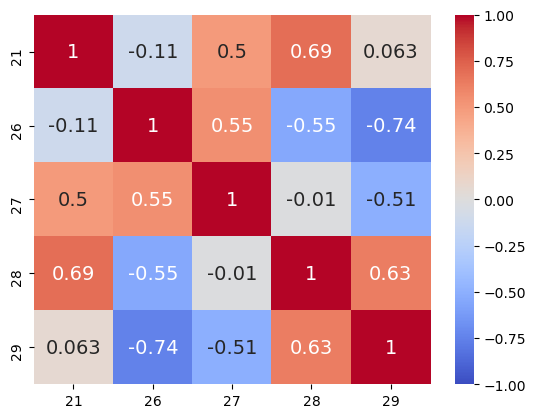

In [9]:
### Filter by correlation ###

# Create correlation matrix
FeaturesPred = pd.DataFrame(FeaturesPred)
FeaturesPred['Hypo'] = HypoOutput
FeaturesCorr = FeaturesPred.corr()
corr_matrix = FeaturesCorr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_keep = [x for x in list(range(Shapelet1Size)) if x not in to_drop]

print(to_drop) 
print(to_keep) 
print('Num of Features to Keep : ', len(to_keep))
# Drop highly correlated features 
FeaturesPred_bycorr = corr_matrix[to_keep]

sns.heatmap(data = FeaturesCorr.loc[to_keep,to_keep], annot=True, annot_kws={"fontsize":14}, cmap='coolwarm', vmin=-1, vmax=1)

In [10]:
### Logistic regression: X = similarity vlaues, y = hypotension label ###

# DataSet Preparation
X = np.array(FeaturesPred.copy().iloc[:,list(FeaturesPred_bycorr.columns)])
X = sm.add_constant(X)
y = HypoOutput.copy()

# Fit Logit Model
LogitModel = sm.Logit(y, X)
result = LogitModel.fit()

Optimization terminated successfully.
         Current function value: 0.549449
         Iterations 5


In [11]:
### Filter by p-value ###

StatResult = pd.DataFrame(np.array([np.array(FeaturesPred_bycorr.columns), 
                                    np.round(result.params[1:], 4), 
                                    np.round(result.pvalues, 4)[1:]]).transpose(), 
                          columns=['Feature_ID', 'NR-method', 'pVal'])
StatResult.insert(1, 'GD-method', np.round(Coef[to_keep],4))
pValSig = StatResult.sort_values('pVal').query('pVal <= 0.3') # pVal <= 0.1 in actual code BUT 0.3 for this simulated example
pValShapIDX = list(pValSig.Feature_ID.astype('int32').values)
pValSig

,Feature_ID,GD-method,NR-method,pVal
3,28,-2.8927,1.6871,0.1576
4,29,0.4064,-0.4431,0.2862


#### Table 4 Confusion Matrix of Maximum Similarity with the Representative Shapes

In [12]:
# extract GenVec layer to obtain representative ABP trends
GenVecp = predict_vals(InputVec, GenVec, ABPInput[0:1, :])
GenVecp.shape

1/1 [==============================] - 0s 46ms/step


(30, 50)

In [13]:
# extract LP5_Dist_sqrt to compute similarity with representative ABP trends
LP5Dist = predict_vals(InputVec, LP5_Dist_sqrt, ABPInput)  # computing distance
LP5Sim = K.exp(-LP5Dist)  # computing similarity
LP5Sim.shape

1/1 [==============================] - 2s 2s/step


TensorShape([500, 183, 30])

In [14]:
### Count the number of samples with maximum similarity to each shape ###

FrequentShap = []
FrequentShapH = [] # Actual hypotension
FrequentShapNH = [] # Actual non-hypotension

for i in range(LP5Sim.shape[0]):
    pValShap = np.array([LP5Sim[i][:,shapIDX] for shapIDX in pValShapIDX])
    FrequentShap.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
    if HypoOutput[i] == 1:
        FrequentShapH.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
    else:
        FrequentShapNH.append(np.bincount(np.argmax(pValShap, axis=0), minlength=len(pValShapIDX)).argmax())
             
FrequentShapH = np.bincount(np.array(FrequentShapH), minlength=len(pValShapIDX))
FreqGenVecH = GenVecp[pValShapIDX]
FrequentShapNH = np.bincount(np.array(FrequentShapNH), minlength=len(pValShapIDX))
FreqGenVecNH = GenVecp[pValShapIDX]

print("Number of max similiarity with each shape for hypotension samples: ", FrequentShapH)
print("Number of max similiarity with each shape for non-hypotension samples: ", FrequentShapNH)

FreqCounts = pd.DataFrame([FrequentShapH, FrequentShapNH], index=['Hypo', 'NonHypo'], columns=pValShapIDX)
FreqCounts

Number of max similiarity with each shape for hypotension samples:  [97 26]
Number of max similiarity with each shape for non-hypotension samples:  [216 161]


,28,29
Hypo,97,26
NonHypo,216,161


In [15]:
### Compute confusion matrix for each shape ###

# get predicted values
ValPred = predict_vals(InputVec, BinOut, ABPInput)
ValPred = np.where(np.reshape(ValPred, -1)>0.5, 1, 0)
SimShap = np.vstack([np.array(FrequentShap), np.array(HypoOutput).squeeze(), np.array(ValPred)]) # axis 1 = True , 2 = Pred

# confusion matrix
for i in range(len(pValShapIDX)):
    SimShap_i = SimShap.transpose()[np.where(SimShap[0]==i)[0]][:,1:]
    cf = metrics.confusion_matrix(SimShap_i[:,0], SimShap_i[:,1])
    cf = pd.DataFrame(cf, columns = ['Predicted as non-hypotension', 'Predicted as hypotension'], index = ['Actual non-hypotension', 'Actual hypotension'])
    print('\n')
    print('ShapeID : ', pValShapIDX[i])
    print(cf)

1/1 [==============================] - 2s 2s/step


ShapeID :  28
                        Predicted as non-hypotension  Predicted as hypotension
Actual non-hypotension                           213                         3
Actual hypotension                                87                        10


ShapeID :  29
                        Predicted as non-hypotension  Predicted as hypotension
Actual non-hypotension                            74                        87
Actual hypotension                                 3                        23


### 2) Exploratory Data Analysis

#### Fig. 3a Representative shapes of local ABP trends 

In [16]:
def plot_ABPtrend(data, lc):

    plt.figure(figsize = (10,3))
    plt.xlim(0,FrameSize)
    plt.plot(data, color=lc, lw=3)
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.xlabel('Local Interval', fontsize='large')
    plt.ylabel('Transformed ABP Value', fontsize='x-large')
    plt.show()

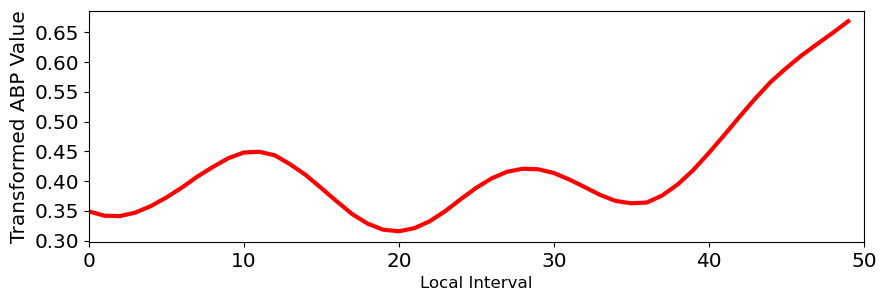

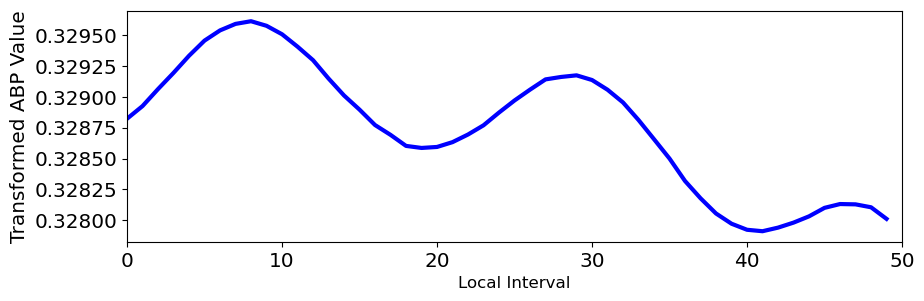

In [17]:
plot_ABPtrend(GenVecp[pValShapIDX][0], lc='red')
plot_ABPtrend(GenVecp[pValShapIDX][1], lc='blue')

#### Fig. 4 Counts for each local interval that is influential in the prediction of hypotension

In [18]:
# extract local importance layer from the model 
LocalIntMat = predict_vals(InputVec, KvRate, ABPInput)
LocalIntMat.shape

1/1 [==============================] - 2s 2s/step


(500, 5, 183)

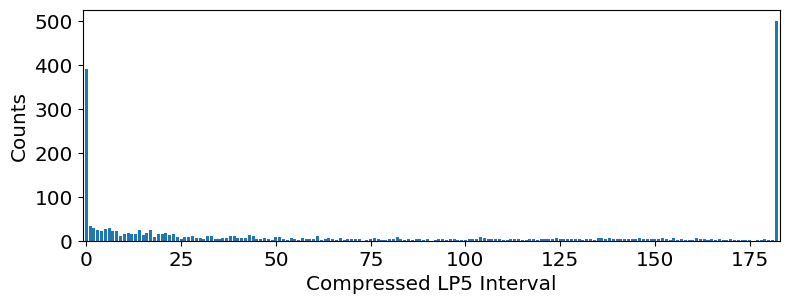

In [19]:
# count the number of values at each interval 
AttMatIDX = np.argmax(LocalIntMat, axis=2)
AttMatrix = np.zeros((LocalIntMat.shape[0],LocalIntMat.shape[2]))
for i in range(AttMatrix.shape[0]):
    AttMatrix[i,AttMatIDX[i,:]] = 1

plt.figure(figsize=(9,3))
plt.xlim(-1,183)
plt.xlabel('Compressed LP5 Interval', fontsize='x-large')
plt.ylabel('Counts', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.bar(np.arange(AttMatrix.shape[1]), np.sum(AttMatrix, axis=0))
plt.show()

## C. Model Interpretability by SHAP

Predicting SHAP values

In [20]:
#explainer = shap.GradientExplainer(Model(InputVec, BinOut), ABPInput, batch_size=1000)
explainer = shap.GradientExplainer(Model(InputVec, BinOut), [ABPInput], batch_size=1000)

SHAPpred_raw = explainer.shap_values(ABPInput)[0]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Computing average SHAP values for hypotension / non-hypotension samples

In [21]:
tf.__version__ , tfp.__version__, shap.__version__, np.__version__

('2.10.0', '0.18.0', '0.41.0', '1.23.4')

In [22]:
SHAPpred_raw = np.concatenate([np.reshape(HypoOutput, (-1,1)), SHAPpred_raw], axis=1)

SHAPpred = SHAPpred_raw[~np.isnan(SHAPpred_raw).any(axis=1)] # delete row if NA
SHAPhypoLAB = SHAPpred[:,0]

SHAPpred_ALL = SHAPpred[:,1:]
SHAPpred_NONHYPO = SHAPpred_ALL[np.where(SHAPhypoLAB==0)]
SHAPpred_HYPO = SHAPpred_ALL[np.where(SHAPhypoLAB==1)]

#### Fig. 5 Mean SHAP values of hypotension and non-hypotension samples

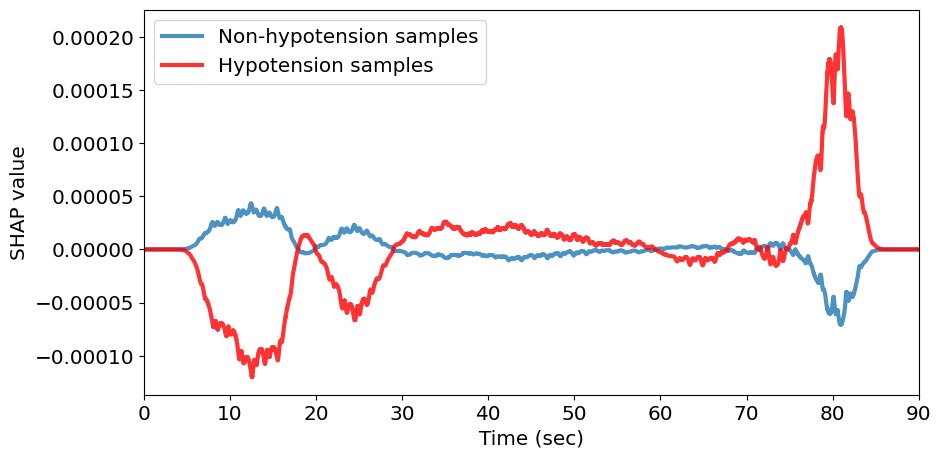

In [23]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(SHAPpred_NONHYPO, axis=0), label='Non-hypotension samples', linewidth=3, color='C0', alpha=0.8)
plt.plot(np.mean(SHAPpred_HYPO, axis=0), label='Hypotension samples', linewidth=3, color='red', alpha=0.8)
plt.xlim(0,9000)
plt.xticks(np.arange(0,9001,1000), np.arange(0,91,10), fontsize='x-large')
plt.xlabel('Time (sec)', fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.ylabel('SHAP value', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig('SHAPaverage.png', bbox_inches='tight')

# End